# prepare data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from torch import nn, optim
import torch
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
from tqdm.auto import tqdm
import timeit
from typing import Tuple, Dict, List
from ax import optimize
#from arff2pandas import a2p

In [2]:
from pandas import DataFrame
from scipy.io import arff

In [3]:
def a2p_load(arff_file,decode_str=True):
    """Reads an ARFF file via scipy and returns a pandas DataFrame.
    Note: same as scipy.io.arff.load, this function does not support ARFF string types.
    
    Parameters
    ----------
    arff_file : str
        Path to ARFF file.
    decode_str : bool
        Wether or not sanitize resulting strings (removes the b'')
        
    Returns
    -------
    pandas.DataFrame
        Columns are ARFF attributes, rows correspond to instances.
    """
    data, meta = arff.loadarff(arff_file) 
    df = DataFrame(data,columns = meta.names())
    if decode_str:        
        df_str = df.select_dtypes(include=['object'])        
        if not df_str.empty:
            df[df_str.columns] = df_str.applymap(lambda x:x.decode('utf-8'))      
    return df

In [4]:
with open('C:\\Users\\Saeth\\Downloads\\ECG5000\\ECG5000_TRAIN.arff') as f:
  train = a2p_load(f)

with open('C:\\Users\\Saeth\\Downloads\\ECG5000\\ECG5000_TEST.arff') as f:
  test = a2p_load(f)

In [5]:
train

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-0.478577,-1.779959,-2.398159,-3.170112,-3.559732,-3.573956,-2.989770,-2.270605,-1.688277,-1.359872,...,1.160885,1.456331,2.209421,2.507175,2.198534,1.705849,1.492642,1.561890,1.520161,4
496,-1.325210,-2.480992,-2.965356,-3.342392,-3.176351,-2.891528,-2.369679,-1.598750,-1.071751,-0.891843,...,-0.172154,-0.864803,-1.549854,-2.460243,-3.366562,-3.466546,-2.718380,-1.855209,-1.539958,4
497,-0.021964,-0.912434,-1.903353,-2.662829,-3.122156,-3.451490,-3.392982,-2.929937,-2.256294,-1.690706,...,1.339479,1.457995,2.128078,2.630759,2.295748,1.764967,1.444280,1.432347,1.457028,4
498,0.288011,-1.098020,-2.500250,-3.598599,-3.650608,-3.281587,-2.231601,-1.250656,-1.072574,-0.434310,...,-0.029242,0.071414,0.118161,-0.071967,-0.171214,0.131211,0.049872,0.010915,-0.081534,5


In [6]:
test

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
0,3.690844,0.711414,-2.114091,-4.141007,-4.574472,-3.431909,-1.950791,-1.107067,-0.632322,0.334577,...,0.022847,0.188937,0.480932,0.629250,0.577291,0.665527,1.035997,1.492287,-1.905073,1
1,-1.348132,-3.996038,-4.226750,-4.251187,-3.477953,-2.228422,-1.808488,-1.534242,-0.779861,-0.397999,...,1.570938,1.591394,1.549193,1.193077,0.515134,0.126274,0.267532,1.071148,-1.164009,1
2,1.024295,-0.590314,-1.916949,-2.806989,-3.527905,-3.638675,-2.779767,-2.019031,-1.980754,-1.440680,...,0.443502,0.827582,1.237007,1.235121,1.738103,1.800767,1.816301,1.473963,1.389767,1
3,0.545657,-1.014383,-2.316698,-3.634040,-4.196857,-3.758093,-3.194444,-2.221764,-1.588554,-1.202146,...,0.777530,1.119240,0.902984,0.554098,0.497053,0.418116,0.703108,1.064602,-0.044853,1
4,0.661133,-1.552471,-3.124641,-4.313351,-4.017042,-3.005993,-1.832411,-1.503886,-1.071705,-0.521316,...,1.280823,1.494315,1.618764,1.447449,1.238577,1.749692,1.986803,1.422756,-0.357784,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,-1.122969,-2.252925,-2.867628,-3.358605,-3.167849,-2.638360,-1.664162,-0.935655,-0.866953,-0.645363,...,-0.472419,-1.310147,-2.029521,-3.221294,-4.176790,-4.009720,-2.874136,-2.008369,-1.808334,4
4496,-0.547705,-1.889545,-2.839779,-3.457912,-3.929149,-3.966026,-3.492560,-2.695270,-1.849691,-1.374321,...,1.258419,1.907530,2.280888,1.895242,1.437702,1.193433,1.261335,1.150449,0.804932,2
4497,-1.351779,-2.209006,-2.520225,-3.061475,-3.065141,-3.030739,-2.622720,-2.044092,-1.295874,-0.733839,...,-1.512234,-2.076075,-2.586042,-3.322799,-3.627311,-3.437038,-2.260023,-1.577823,-0.684531,2
4498,-1.124432,-1.905039,-2.192707,-2.904320,-2.900722,-2.761252,-2.569705,-2.043893,-1.490538,-0.938473,...,-2.821782,-3.268355,-3.634981,-3.168765,-2.245878,-1.262260,-0.443307,-0.559769,0.108568,2


In [7]:
df = pd.concat([train, test])
df = df.sample(frac=1.0)
df.shape

(5000, 141)

In [8]:
df

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
1665,-0.106352,-1.633382,-3.061277,-4.103547,-3.775236,-2.932114,-2.010609,-1.804516,-1.214407,-0.545108,...,0.963326,0.869398,0.994685,0.898456,0.835330,0.877105,1.004942,1.746857,0.938820,1
459,-0.972069,-2.090552,-2.195810,-2.732896,-3.005769,-2.933421,-2.812995,-2.554974,-2.175364,-1.640098,...,-2.138709,-2.454332,-2.897430,-3.123211,-3.099517,-2.379844,-1.399522,-1.023969,0.308325,2
3094,-2.699398,-3.456905,-3.039923,-3.314794,-2.448838,-2.087063,-1.304534,-1.211361,-1.135972,-0.906375,...,2.559854,2.092224,1.629720,1.286314,1.359192,1.044833,1.193312,0.457739,1.105114,4
3518,1.106434,0.042032,-0.895514,-1.815491,-2.661493,-3.207295,-3.229629,-2.914336,-2.500017,-2.024511,...,-1.909239,-2.266914,-2.572424,-2.869457,-3.036636,-2.642590,-1.701219,-0.641542,0.859312,2
2884,-0.671003,-1.351616,-1.548438,-1.825183,-2.129991,-2.412671,-2.310799,-2.021234,-1.465961,-0.761740,...,-1.102836,-1.758338,-2.420676,-3.466719,-4.271179,-4.656391,-3.737983,-2.801066,-1.859427,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4144,1.143205,0.981799,0.503426,-0.093576,-0.585992,-0.846767,-1.079373,-1.411446,-1.592628,-1.594404,...,-1.645617,-1.977822,-2.604773,-3.074647,-3.525217,-4.153186,-4.129235,-4.593642,-2.780053,2
3350,-0.050916,-1.154070,-1.951808,-2.692316,-3.234723,-3.523636,-3.349909,-2.661394,-1.744920,-1.079460,...,-1.415889,-1.836682,-2.394117,-3.137480,-3.466479,-2.840671,-1.349003,-0.335124,0.242572,4
1245,2.157729,0.396731,-1.981511,-3.455137,-4.300857,-4.617203,-3.531008,-2.140402,-1.981225,-1.207026,...,0.568602,0.870262,1.025789,1.766755,1.674374,1.804323,1.259629,1.370336,1.935005,1
2923,-1.029610,-2.236788,-2.892529,-3.458219,-3.351253,-3.312254,-2.894718,-2.347848,-1.683868,-1.046600,...,-1.471381,-1.893371,-2.748511,-3.463847,-3.284562,-2.332802,-1.001085,-0.430289,0.159438,2


In [9]:
df['target'].value_counts()

1    2919
2    1767
4     194
3      96
5      24
Name: target, dtype: int64

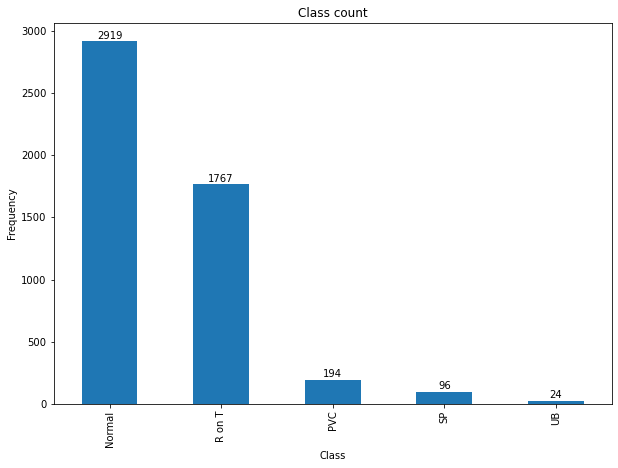

In [10]:
# class count plot

frequencies = list(df['target'].value_counts())
# In my original code I create a series and run on that,
# so for consistency I create a series from the list.
freq_series = pd.Series(frequencies)

x_labels = ['Normal','R on T','PVC','SP','UB']

# Plot the figure.
plt.figure(figsize=(10, 7))
ax = freq_series.plot(kind="bar")
ax.set_title("Class count")
ax.set_xlabel("Class")
ax.set_ylabel("Frequency")
ax.set_xticklabels(x_labels)

rects = ax.patches

# Make some labels.
labels = frequencies

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    )

plt.show()

In [11]:
# sognal plot per class
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)
  ax.set_xlabel("Time step")
  ax.set_ylabel("Signal")

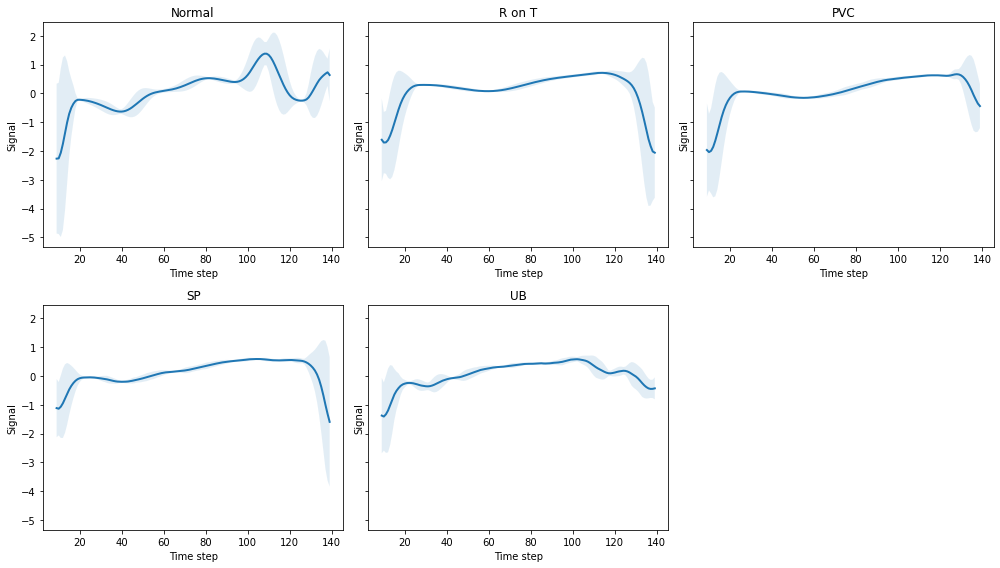

In [12]:
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
  plot_time_series_class(data, x_labels[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout()

In [13]:
df.target.unique()

array(['1', '2', '4', '3', '5'], dtype=object)

In [14]:
normal_df = df[df.target == '1'].drop(labels='target', axis=1)
normal_df.shape

(2919, 140)

In [15]:
anomaly_df = df[df.target != '1'].drop(labels='target', axis=1)
anomaly_df.shape

(2081, 140)

In [16]:
# train 70%, validate 20%, test 10%
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.3,
  random_state=42
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33, 
  random_state=42
)

In [17]:
len(train_df), len(val_df), len(test_df)

(2043, 586, 290)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [19]:
# custom dataset
class SignalDataset(Dataset):
    def __init__(self,data: DataFrame):
        self.data = data
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int)-> torch.Tensor :
        x = self.data.iloc[index].values
        x = torch.from_numpy(x).float()
        x = torch.unsqueeze(x, 1)
        return  x

In [20]:
train_dataset = SignalDataset(train_df) 
val_dataset = SignalDataset(val_df)
test_dataset = SignalDataset(test_df)
anomaly_dataset = SignalDataset(anomaly_df)
nomal_dataset = SignalDataset(normal_df)

batch_size = 64
train_dataloader = DataLoader(train_dataset,batch_size)
val_dataloader = DataLoader(val_dataset,batch_size)
test_dataloader = DataLoader(test_dataset,batch_size)
anomaly_dataloader = DataLoader(anomaly_dataset,batch_size)
normal_dataloader = DataLoader(nomal_dataset,batch_size)

In [21]:
# check data size per batch
for batch, sample in enumerate(train_dataloader):
    print(sample)
    print(sample.shape)
    print(torch.squeeze(sample).shape)
    print(sample[0, :, :].shape)
    break

tensor([[[-0.8254],
         [-2.0670],
         [-2.9103],
         ...,
         [-0.4735],
         [-0.5885],
         [-1.7267]],

        [[-1.7551],
         [-3.5878],
         [-4.2289],
         ...,
         [ 1.1273],
         [ 1.2898],
         [ 0.1863]],

        [[-0.0975],
         [-2.1567],
         [-3.6392],
         ...,
         [ 0.8159],
         [ 0.8518],
         [-0.3883]],

        ...,

        [[ 1.5568],
         [-0.4102],
         [-2.1317],
         ...,
         [ 2.1685],
         [ 1.3280],
         [ 0.7381]],

        [[-1.0490],
         [-2.4677],
         [-2.9992],
         ...,
         [-1.9932],
         [-1.2278],
         [-0.9433]],

        [[-1.3368],
         [-3.4108],
         [-4.2164],
         ...,
         [ 0.8927],
         [ 0.5131],
         [-2.0282]]])
torch.Size([64, 140, 1])
torch.Size([64, 140])
torch.Size([140, 1])


# model 1 basic lstm

In [22]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss = 0

    # Loop through data loader data batches
    for batch, sample in enumerate(dataloader):
        # Send data to target device
        batch_size, seq_len, feature = sample.shape
        sample = sample.to(device)

        # 1. Forward pass
        y_pred = model(sample) # [batch, sequence length, hidden unit]

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred.reshape(batch_size, seq_len), sample.reshape(batch_size, seq_len))
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        #delta_y = y.detach().cpu().numpy() - y_pred.detach().cpu().numpy()
        #train_acc+= (np.sum((y.detach().cpu().numpy()-delta_y)/y.detach().cpu().numpy())/len(y))*100

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    #train_acc = train_acc / len(dataloader)
    return train_loss

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device):
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss = 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, sample in enumerate(dataloader):
            # Send data to target device
            sample = sample.to(device)
            batch_size, seq_len, feature = sample.shape

            # 1. Forward pass
            test_pred_logits = model(sample) # [batch, sequence length, hidden unit]

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits.reshape(batch_size, seq_len), sample.reshape(batch_size,seq_len))
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            #delta_y = y.detach().cpu().numpy() - test_pred_logits.detach().cpu().numpy()
            #test_acc+= (np.sum((y.detach().cpu().numpy()-delta_y)/y.detach().cpu().numpy())/len(y))*100

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    #test_acc = test_acc / len(dataloader)
    return test_loss

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    
    # track accuracy (if it doesn't increase, reducr the learning rate)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=1, verbose=True)
    
    #early_stop_count=0
    
    # Create empty results dictionary
    results = {"train_loss": [],
               "test_loss": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        start = timeit.default_timer()
        train_loss = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)
        
        stop = timeit.default_timer()

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"time (sec): {stop-start:.2f}"
        )
        
        #scheduler.step(test_loss) # monitor test accuracy
        
        # early stopping
        #if epoch==0:
            #pass
        #else:
            #if  results["test_loss"][-1]-test_loss <= 0.005:
                #early_stop_count+=1
                #if early_stop_count==4:
                    #print('early stopping!')
                    #break
            #else:
                #early_stop_count=0
        
        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)
        
                
    # Return the filled results at the end of the epochs
    return results

In [23]:
# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "test_loss": [...],}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]


    epochs = range(1, len(results["train_loss"])+1)

    plt.figure(figsize=(15, 7))
    # Plot loss
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.xticks(epochs)
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    print('average train loss:', sum(loss)/len(loss))
    print('average test loss:', sum(test_loss)/len(test_loss))

In [24]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [25]:
class stackedLstm(nn.Module):
    def __init__(self, input_size: int, hidden_size : int, num_layers : int) -> None:
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstms = nn.LSTM(input_size = self.input_size, hidden_size =self.hidden_size, num_layers  = self.num_layers, batch_first=True)
        #self.linear = nn.Linear(in_features=hidden_size, out_features=140)
        
        
    def forward(self, x):
        output, (h,c) = self.lstms(x)
        #output = output[:, -1, :] # [batch, seq lenght, hidden units]
        #output = self.linear(output)
        return output
set_seeds()
model1 = stackedLstm(1, 1, 50).to(device)

In [26]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model1, 
        input_size=(64, 140, 1), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=15,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape     Output Shape    Param #         Trainable
stackedLstm (stackedLstm)                [64, 140, 1]    [64, 140, 1]    --              True
├─LSTM (lstms)                           [64, 140, 1]    [64, 140, 1]    800             True
Total params: 800
Trainable params: 800
Non-trainable params: 0
Total mult-adds (M): 7.17
Input size (MB): 0.04
Forward/backward pass size (MB): 0.07
Params size (MB): 0.00
Estimated Total Size (MB): 0.11

## train

In [27]:
# Define loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-3)
set_seeds()
results = train(model=model1,
                       train_dataloader=train_dataloader,
                       test_dataloader=val_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=30,
                       device=device)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9926 | test_loss: 0.9926 | time (sec): 2.11
Epoch: 2 | train_loss: 0.9924 | test_loss: 0.9923 | time (sec): 1.86
Epoch: 3 | train_loss: 0.9920 | test_loss: 0.9917 | time (sec): 1.85
Epoch: 4 | train_loss: 0.9909 | test_loss: 0.9898 | time (sec): 1.85
Epoch: 5 | train_loss: 0.9872 | test_loss: 0.9831 | time (sec): 1.85
Epoch: 6 | train_loss: 0.9724 | test_loss: 0.9549 | time (sec): 1.83
Epoch: 7 | train_loss: 0.9189 | test_loss: 0.8695 | time (sec): 1.88
Epoch: 8 | train_loss: 0.8124 | test_loss: 0.7379 | time (sec): 1.85
Epoch: 9 | train_loss: 0.6977 | test_loss: 0.6736 | time (sec): 1.83
Epoch: 10 | train_loss: 0.6786 | test_loss: 0.6655 | time (sec): 1.81
Epoch: 11 | train_loss: 0.6728 | test_loss: 0.6605 | time (sec): 1.86
Epoch: 12 | train_loss: 0.6687 | test_loss: 0.6568 | time (sec): 1.87
Epoch: 13 | train_loss: 0.6655 | test_loss: 0.6537 | time (sec): 1.90
Epoch: 14 | train_loss: 0.6629 | test_loss: 0.6511 | time (sec): 2.01
Epoch: 15 | train_loss: 0.660

average train loss: 0.7369870033115149
average test loss: 0.7231053400039672


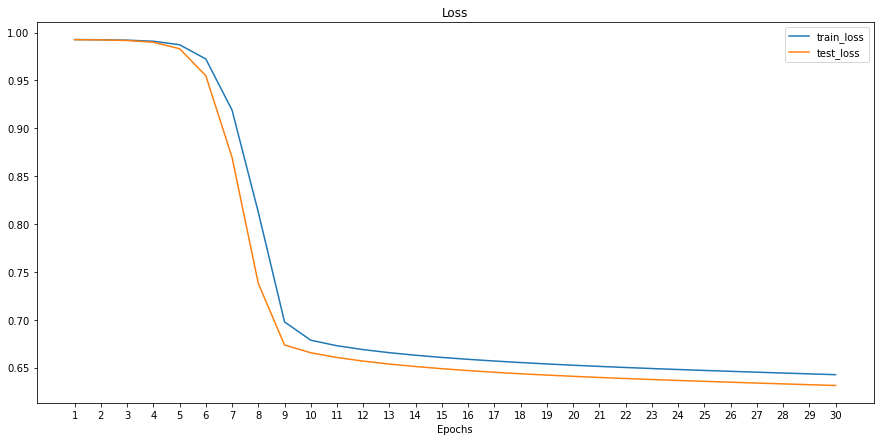

In [28]:
plot_loss_curves(results)

## loss plot

In [29]:
batch_size = 1
anomaly_dataloader2 = DataLoader(anomaly_dataset,batch_size)
normal_dataloader2 = DataLoader(nomal_dataset,batch_size)

In [30]:
# nomal class loss plot
def prediction_loss(data, model):
    loss_his = []
    #hn , cn = model.init()
    model.eval()
    with torch.inference_mode():
      for batch, sample in enumerate(data):
        # Send data and targets to target device
        sample = sample.to(device)
        batch_size, seq_len, feature = sample.shape
        # Do the forward pass
        test_pred_logits = model(sample) # [batch, sequence length, hidden unit]
        # 2. Calculate and accumulate loss
        loss = loss_fn(test_pred_logits.reshape(batch_size, seq_len), sample.reshape(batch_size,seq_len))
        loss_his.append(loss.item())
    return loss_his

In [31]:
normal_loss = prediction_loss(normal_dataloader2, model1)

In [32]:
sum(normal_loss)/len(normal_loss)

0.640778514886809

<AxesSubplot:ylabel='Count'>

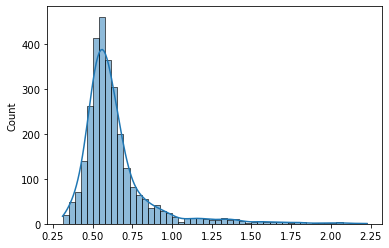

In [33]:
sns.histplot(normal_loss, bins=50, kde=True)

In [34]:
abnormal_loss = prediction_loss(anomaly_dataloader2, model1)

In [35]:
sum(abnormal_loss)/len(abnormal_loss)

1.04053933309111

<AxesSubplot:ylabel='Count'>

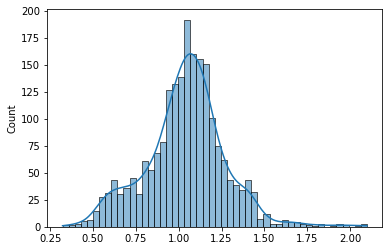

In [36]:
sns.histplot(abnormal_loss, bins=50, kde=True)

## threshold optimization

In [37]:
# test the threshole
def result_thres(thres, anomaly_loss, normal_loss):
    anomaly_count = len([i for i in abnormal_loss if i>=thres])
    normal_count = len([i for i in normal_loss if i<=thres])
    print(f'Correct anomaly predictions: {anomaly_count}/{len(anomaly_loss)}', 'accuracy: ', (anomaly_count/len(anomaly_loss))*100)
    print(f'Correct normal predictions: {normal_count}/{len(normal_loss)}', 'accuracy: ', (normal_count/len(normal_loss))*100)
    return 0.5*(anomaly_count/len(anomaly_loss)) + 0.5*(normal_count/len(normal_loss))

In [38]:
result_thres(0.9, abnormal_loss, normal_loss)

Correct anomaly predictions: 1610/2081 accuracy:  77.36665064872658
Correct normal predictions: 2664/2919 accuracy:  91.26413155190134


0.8431539110031396

In [39]:
best_parameters, best_values, experiment, modelX = optimize(
    parameters=[
        {
            "name": "thres",
            "type": "range",
            "bounds": [0.2, 2.0],
        },
        ],
        # Booth function
        evaluation_function=lambda p: result_thres(p['thres'], abnormal_loss, normal_loss),
        minimize=False,
        total_trials=50,
    )
#print(best_parameters, best_values)

[INFO 10-21 21:40:53] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter thres. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 10-21 21:40:53] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='thres', parameter_type=FLOAT, range=[0.2, 2.0])], parameter_constraints=[]).
[INFO 10-21 21:40:53] ax.modelbridge.dispatch_utils: Using Bayesian optimization since there are more ordered parameters than there are categories for the unordered categorical parameters.
[INFO 10-21 21:40:53] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 trials, GPEI for subsequent trials]). Iterations after 5 will take longer to generate due to  model-fitting.
[INFO 10-21 21:40:53] ax.service.managed_loop: Started full optimization with 50 steps.
[INFO 1

Correct anomaly predictions: 2081/2081 accuracy:  100.0
Correct normal predictions: 0/2919 accuracy:  0.0
Correct anomaly predictions: 2074/2081 accuracy:  99.66362325804901
Correct normal predictions: 183/2919 accuracy:  6.269270298047276
Correct anomaly predictions: 1893/2081 accuracy:  90.96588178760211
Correct normal predictions: 2288/2919 accuracy:  78.38300787941075
Correct anomaly predictions: 1819/2081 accuracy:  87.40989908697742
Correct normal predictions: 2484/2919 accuracy:  85.09763617677287
Correct anomaly predictions: 27/2081 accuracy:  1.2974531475252282
Correct normal predictions: 2887/2919 accuracy:  98.90373415553272


C:\Users\Saeth\anaconda3\lib\site-packages\gpytorch\lazy\lazy_tensor.py:1811: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\BatchLinearAlgebra.cpp:2189.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution
[INFO 10-21 21:40:53] ax.service.managed_loop: Running optimization trial 7...


Correct anomaly predictions: 1261/2081 accuracy:  60.59586737145604
Correct normal predictions: 2744/2919 accuracy:  94.00479616306954


[INFO 10-21 21:40:53] ax.service.managed_loop: Running optimization trial 8...


Correct anomaly predictions: 1740/2081 accuracy:  83.61364728495916
Correct normal predictions: 2577/2919 accuracy:  88.28365878725592


[INFO 10-21 21:40:53] ax.service.managed_loop: Running optimization trial 9...


Correct anomaly predictions: 4/2081 accuracy:  0.19221528111484865
Correct normal predictions: 2910/2919 accuracy:  99.69167523124358


[INFO 10-21 21:40:54] ax.service.managed_loop: Running optimization trial 10...


Correct anomaly predictions: 1804/2081 accuracy:  86.68909178279674
Correct normal predictions: 2515/2919 accuracy:  86.15964371360056
Correct anomaly predictions: 253/2081 accuracy:  12.157616530514176
Correct normal predictions: 2823/2919 accuracy:  96.71120246659814


[INFO 10-21 21:40:54] ax.service.managed_loop: Running optimization trial 11...
[INFO 10-21 21:40:54] ax.service.managed_loop: Running optimization trial 12...


Correct anomaly predictions: 1811/2081 accuracy:  87.02546852474772
Correct normal predictions: 2500/2919 accuracy:  85.64576909900651


[INFO 10-21 21:40:54] ax.service.managed_loop: Running optimization trial 13...


Correct anomaly predictions: 1794/2081 accuracy:  86.2085535800096
Correct normal predictions: 2536/2919 accuracy:  86.8790681740322


[INFO 10-21 21:40:55] ax.service.managed_loop: Running optimization trial 14...


Correct anomaly predictions: 1834/2081 accuracy:  88.1307063911581
Correct normal predictions: 2455/2919 accuracy:  84.1041452552244


[INFO 10-21 21:40:55] ax.service.managed_loop: Running optimization trial 15...


Correct anomaly predictions: 1637/2081 accuracy:  78.66410379625181
Correct normal predictions: 2647/2919 accuracy:  90.68174032202809


[INFO 10-21 21:40:55] ax.service.managed_loop: Running optimization trial 16...


Correct anomaly predictions: 1806/2081 accuracy:  86.78519942335416
Correct normal predictions: 2506/2919 accuracy:  85.85131894484412


[INFO 10-21 21:40:56] ax.service.managed_loop: Running optimization trial 17...


Correct anomaly predictions: 1777/2081 accuracy:  85.3916386352715
Correct normal predictions: 2546/2919 accuracy:  87.22165125042824


[INFO 10-21 21:40:56] ax.service.managed_loop: Running optimization trial 18...


Correct anomaly predictions: 1799/2081 accuracy:  86.44882268140317
Correct normal predictions: 2525/2919 accuracy:  86.50222678999657


[INFO 10-21 21:40:56] ax.service.managed_loop: Running optimization trial 19...


Correct anomaly predictions: 1816/2081 accuracy:  87.26573762614129
Correct normal predictions: 2492/2919 accuracy:  85.37170263788968


[INFO 10-21 21:40:57] ax.service.managed_loop: Running optimization trial 20...


Correct anomaly predictions: 1806/2081 accuracy:  86.78519942335416
Correct normal predictions: 2508/2919 accuracy:  85.91983556012333


[INFO 10-21 21:40:57] ax.service.managed_loop: Running optimization trial 21...


Correct anomaly predictions: 1786/2081 accuracy:  85.82412301777993
Correct normal predictions: 2539/2919 accuracy:  86.98184309695101


[INFO 10-21 21:40:57] ax.service.managed_loop: Running optimization trial 22...


Correct anomaly predictions: 1751/2081 accuracy:  84.142239308025
Correct normal predictions: 2566/2919 accuracy:  87.90681740322029


[INFO 10-21 21:40:57] ax.service.managed_loop: Running optimization trial 23...


Correct anomaly predictions: 1801/2081 accuracy:  86.5449303219606
Correct normal predictions: 2520/2919 accuracy:  86.33093525179856


[INFO 10-21 21:40:58] ax.service.managed_loop: Running optimization trial 24...


Correct anomaly predictions: 1810/2081 accuracy:  86.977414704469
Correct normal predictions: 2503/2919 accuracy:  85.74854402192533


[INFO 10-21 21:40:58] ax.service.managed_loop: Running optimization trial 25...


Correct anomaly predictions: 1796/2081 accuracy:  86.30466122056704
Correct normal predictions: 2529/2919 accuracy:  86.63926002055499


[INFO 10-21 21:40:58] ax.service.managed_loop: Running optimization trial 26...


Correct anomaly predictions: 1806/2081 accuracy:  86.78519942335416
Correct normal predictions: 2507/2919 accuracy:  85.88557725248373


[INFO 10-21 21:40:58] ax.service.managed_loop: Running optimization trial 27...


Correct anomaly predictions: 1805/2081 accuracy:  86.73714560307545
Correct normal predictions: 2513/2919 accuracy:  86.09112709832134


[INFO 10-21 21:40:59] ax.service.managed_loop: Running optimization trial 28...


Correct anomaly predictions: 1800/2081 accuracy:  86.49687650168188
Correct normal predictions: 2521/2919 accuracy:  86.36519355943817


C:\Users\Saeth\anaconda3\lib\site-packages\botorch\optim\optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
[INFO 10-21 21:40:59] ax.service.managed_loop: Running optimization trial 29...


Correct anomaly predictions: 1799/2081 accuracy:  86.44882268140317
Correct normal predictions: 2525/2919 accuracy:  86.50222678999657


C:\Users\Saeth\anaconda3\lib\site-packages\botorch\optim\optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
[INFO 10-21 21:41:00] ax.service.managed_loop: Running optimization trial 30...


Correct anomaly predictions: 1806/2081 accuracy:  86.78519942335416
Correct normal predictions: 2506/2919 accuracy:  85.85131894484412


C:\Users\Saeth\anaconda3\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[INFO 10-21 21:41:00] ax.service.managed_loop: Running optimization trial 31...


Correct anomaly predictions: 1805/2081 accuracy:  86.73714560307545
Correct normal predictions: 2513/2919 accuracy:  86.09112709832134


C:\Users\Saeth\anaconda3\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[INFO 10-21 21:41:00] ax.service.managed_loop: Running optimization trial 32...


Correct anomaly predictions: 1796/2081 accuracy:  86.30466122056704
Correct normal predictions: 2531/2919 accuracy:  86.7077766358342


C:\Users\Saeth\anaconda3\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[INFO 10-21 21:41:01] ax.service.managed_loop: Running optimization trial 33...


Correct anomaly predictions: 1802/2081 accuracy:  86.5929841422393
Correct normal predictions: 2520/2919 accuracy:  86.33093525179856


C:\Users\Saeth\anaconda3\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[INFO 10-21 21:41:01] ax.service.managed_loop: Running optimization trial 34...


Correct anomaly predictions: 1804/2081 accuracy:  86.68909178279674
Correct normal predictions: 2516/2919 accuracy:  86.19390202124015


C:\Users\Saeth\anaconda3\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[INFO 10-21 21:41:01] ax.service.managed_loop: Running optimization trial 35...


Correct anomaly predictions: 1798/2081 accuracy:  86.40076886112446
Correct normal predictions: 2525/2919 accuracy:  86.50222678999657


C:\Users\Saeth\anaconda3\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[INFO 10-21 21:41:01] ax.service.managed_loop: Running optimization trial 36...


Correct anomaly predictions: 1796/2081 accuracy:  86.30466122056704
Correct normal predictions: 2530/2919 accuracy:  86.67351832819459


C:\Users\Saeth\anaconda3\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[INFO 10-21 21:41:02] ax.service.managed_loop: Running optimization trial 37...


Correct anomaly predictions: 1794/2081 accuracy:  86.2085535800096
Correct normal predictions: 2536/2919 accuracy:  86.8790681740322


C:\Users\Saeth\anaconda3\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[INFO 10-21 21:41:02] ax.service.managed_loop: Running optimization trial 38...


Correct anomaly predictions: 1784/2081 accuracy:  85.72801537722249
Correct normal predictions: 2539/2919 accuracy:  86.98184309695101


C:\Users\Saeth\anaconda3\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[INFO 10-21 21:41:02] ax.service.managed_loop: Running optimization trial 39...


Correct anomaly predictions: 1819/2081 accuracy:  87.40989908697742
Correct normal predictions: 2486/2919 accuracy:  85.16615279205207


C:\Users\Saeth\anaconda3\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[INFO 10-21 21:41:03] ax.service.managed_loop: Running optimization trial 40...


Correct anomaly predictions: 1800/2081 accuracy:  86.49687650168188
Correct normal predictions: 2523/2919 accuracy:  86.43371017471738


C:\Users\Saeth\anaconda3\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[INFO 10-21 21:41:03] ax.service.managed_loop: Running optimization trial 41...


Correct anomaly predictions: 1797/2081 accuracy:  86.35271504084575
Correct normal predictions: 2529/2919 accuracy:  86.63926002055499


C:\Users\Saeth\anaconda3\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[INFO 10-21 21:41:03] ax.service.managed_loop: Running optimization trial 42...


Correct anomaly predictions: 1804/2081 accuracy:  86.68909178279674
Correct normal predictions: 2519/2919 accuracy:  86.29667694415896


C:\Users\Saeth\anaconda3\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[INFO 10-21 21:41:04] ax.service.managed_loop: Running optimization trial 43...


Correct anomaly predictions: 1811/2081 accuracy:  87.02546852474772
Correct normal predictions: 2500/2919 accuracy:  85.64576909900651


C:\Users\Saeth\anaconda3\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[INFO 10-21 21:41:04] ax.service.managed_loop: Running optimization trial 44...


Correct anomaly predictions: 1790/2081 accuracy:  86.01633829889475
Correct normal predictions: 2536/2919 accuracy:  86.8790681740322


C:\Users\Saeth\anaconda3\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[INFO 10-21 21:41:04] ax.service.managed_loop: Running optimization trial 45...


Correct anomaly predictions: 1794/2081 accuracy:  86.2085535800096
Correct normal predictions: 2533/2919 accuracy:  86.77629325111339


C:\Users\Saeth\anaconda3\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[INFO 10-21 21:41:04] ax.service.managed_loop: Running optimization trial 46...


Correct anomaly predictions: 1798/2081 accuracy:  86.40076886112446
Correct normal predictions: 2528/2919 accuracy:  86.60500171291538


C:\Users\Saeth\anaconda3\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[INFO 10-21 21:41:05] ax.service.managed_loop: Running optimization trial 47...


Correct anomaly predictions: 1799/2081 accuracy:  86.44882268140317
Correct normal predictions: 2525/2919 accuracy:  86.50222678999657


C:\Users\Saeth\anaconda3\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[INFO 10-21 21:41:05] ax.service.managed_loop: Running optimization trial 48...


Correct anomaly predictions: 1801/2081 accuracy:  86.5449303219606
Correct normal predictions: 2520/2919 accuracy:  86.33093525179856


C:\Users\Saeth\anaconda3\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[INFO 10-21 21:41:05] ax.service.managed_loop: Running optimization trial 49...


Correct anomaly predictions: 1804/2081 accuracy:  86.68909178279674
Correct normal predictions: 2515/2919 accuracy:  86.15964371360056


C:\Users\Saeth\anaconda3\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[INFO 10-21 21:41:06] ax.service.managed_loop: Running optimization trial 50...


Correct anomaly predictions: 1800/2081 accuracy:  86.49687650168188
Correct normal predictions: 2524/2919 accuracy:  86.46796848235697


C:\Users\Saeth\anaconda3\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


Correct anomaly predictions: 1794/2081 accuracy:  86.2085535800096
Correct normal predictions: 2535/2919 accuracy:  86.84480986639261


In [40]:
print(best_parameters, best_values)

{'thres': 0.790663826820664} ({'objective': 0.8645027735253623}, {'objective': {'objective': 3.6206614139289516e-08}})


## final results

In [41]:
result_thres(best_parameters['thres'], abnormal_loss, normal_loss)

Correct anomaly predictions: 1798/2081 accuracy:  86.40076886112446
Correct normal predictions: 2525/2919 accuracy:  86.50222678999657


0.8645149782556052

# model 2 encoder-decoder

In [42]:
class encoderDecoder(nn.Module):
    def __init__(self, input_size: int, hidden_size : int, num_layers : int) -> None:
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.encoder = nn.LSTM(input_size = self.input_size, hidden_size =self.hidden_size, num_layers  = self.num_layers, batch_first=True)
        self.decoder = nn.LSTM(input_size = self.hidden_size, hidden_size =self.input_size, num_layers  = self.num_layers, batch_first=True)
        #self.linear = nn.Linear(in_features=hidden_size, out_features=140)
        
        
    def forward(self, x):
        output, (h,c) = self.encoder(x) # in: [batch, seq_len, in_feature], out: [batch, seq_len, hidden]
        output, (h,c) = self.decoder(output) # out: [batch, seq_len, hidden]
        #output = output[:, -1, :] # [batch, seq lenght, hidden units]
        #output = self.linear(output)
        return output

In [43]:
set_seeds()
model2 = encoderDecoder(1, 100, 1).to(device)

In [44]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model2, 
        input_size=(64, 140, 1), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=15,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape     Output Shape    Param #         Trainable
encoderDecoder (encoderDecoder)          [64, 140, 1]    [64, 140, 1]    --              True
├─LSTM (encoder)                         [64, 140, 1]    [64, 140, 100]  41,200          True
├─LSTM (decoder)                         [64, 140, 100]  [64, 140, 1]    412             True
Total params: 41,612
Trainable params: 41,612
Non-trainable params: 0
Total mult-adds (M): 372.84
Input size (MB): 0.04
Forward/backward pass size (MB): 7.24
Params size (MB): 0.17
Estimated Total Size (MB): 7.44

## train

In [45]:
# Define loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)
set_seeds()
results = train(model=model2,
                       train_dataloader=train_dataloader,
                       test_dataloader=val_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=30,
                       device=device)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6789 | test_loss: 0.5036 | time (sec): 0.61
Epoch: 2 | train_loss: 0.4650 | test_loss: 0.4245 | time (sec): 0.36
Epoch: 3 | train_loss: 0.4024 | test_loss: 0.3735 | time (sec): 0.36
Epoch: 4 | train_loss: 0.3615 | test_loss: 0.3450 | time (sec): 0.36
Epoch: 5 | train_loss: 0.3447 | test_loss: 0.3340 | time (sec): 0.36
Epoch: 6 | train_loss: 0.3342 | test_loss: 0.3261 | time (sec): 0.36
Epoch: 7 | train_loss: 0.3291 | test_loss: 0.3224 | time (sec): 0.36
Epoch: 8 | train_loss: 0.3243 | test_loss: 0.3178 | time (sec): 0.36
Epoch: 9 | train_loss: 0.3229 | test_loss: 0.3172 | time (sec): 0.36
Epoch: 10 | train_loss: 0.3200 | test_loss: 0.3144 | time (sec): 0.36
Epoch: 11 | train_loss: 0.3189 | test_loss: 0.3165 | time (sec): 0.36
Epoch: 12 | train_loss: 0.3180 | test_loss: 0.3124 | time (sec): 0.36
Epoch: 13 | train_loss: 0.3165 | test_loss: 0.3115 | time (sec): 0.36
Epoch: 14 | train_loss: 0.3162 | test_loss: 0.3115 | time (sec): 0.36
Epoch: 15 | train_loss: 0.315

average train loss: 0.33873356285815437
average test loss: 0.3254735551277797


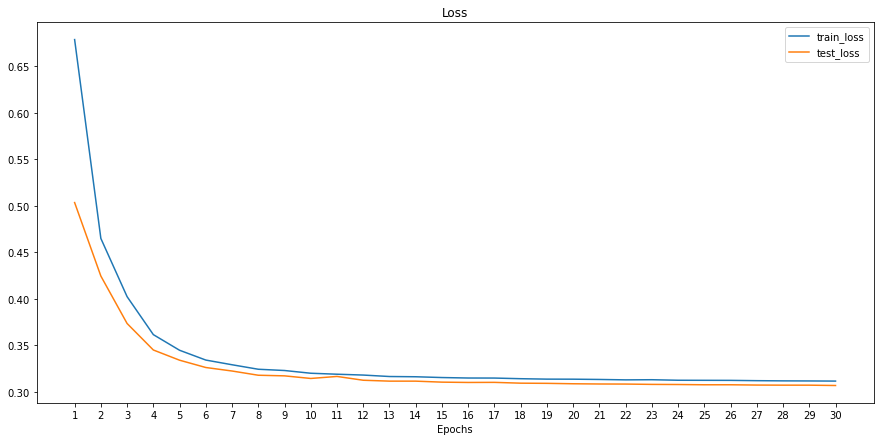

In [46]:
plot_loss_curves(results)

## loss plot

In [47]:
normal_loss = prediction_loss(normal_dataloader2, model2)

In [48]:
sum(normal_loss)/len(normal_loss)

0.31118265563273073

<AxesSubplot:ylabel='Count'>

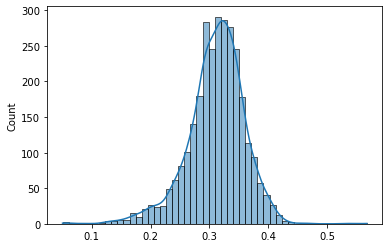

In [49]:
sns.histplot(normal_loss, bins=50, kde=True)

In [50]:
abnormal_loss = prediction_loss(anomaly_dataloader2, model1)

In [51]:
sum(abnormal_loss)/len(abnormal_loss)

1.04053933309111

<AxesSubplot:ylabel='Count'>

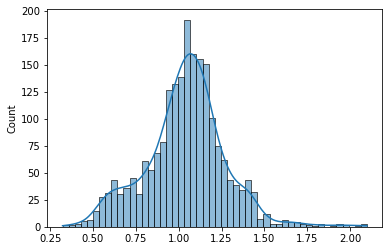

In [52]:
sns.histplot(abnormal_loss, bins=50, kde=True)

## threshold optimization

In [53]:
result_thres(0.9, abnormal_loss, normal_loss)

Correct anomaly predictions: 1610/2081 accuracy:  77.36665064872658
Correct normal predictions: 2919/2919 accuracy:  100.0


0.8868332532436329

In [54]:
best_parameters, best_values, experiment, modelX = optimize(
    parameters=[
        {
            "name": "thres",
            "type": "range",
            "bounds": [0.1, 2.0],
        },
        ],
        # Booth function
        evaluation_function=lambda p: result_thres(p['thres'], abnormal_loss, normal_loss),
        minimize=False,
        total_trials=50,
    )
#print(best_parameters, best_values)

[INFO 10-21 21:41:29] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter thres. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 10-21 21:41:29] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='thres', parameter_type=FLOAT, range=[0.1, 2.0])], parameter_constraints=[]).
[INFO 10-21 21:41:29] ax.modelbridge.dispatch_utils: Using Bayesian optimization since there are more ordered parameters than there are categories for the unordered categorical parameters.
[INFO 10-21 21:41:29] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 trials, GPEI for subsequent trials]). Iterations after 5 will take longer to generate due to  model-fitting.
[INFO 10-21 21:41:29] ax.service.managed_loop: Started full optimization with 50 steps.
[INFO 1

Correct anomaly predictions: 2081/2081 accuracy:  100.0
Correct normal predictions: 24/2919 accuracy:  0.8221993833504625
Correct anomaly predictions: 2079/2081 accuracy:  99.90389235944258
Correct normal predictions: 2471/2919 accuracy:  84.65227817745803
Correct anomaly predictions: 1966/2081 accuracy:  94.4738106679481
Correct normal predictions: 2919/2919 accuracy:  100.0
Correct anomaly predictions: 1893/2081 accuracy:  90.96588178760211
Correct normal predictions: 2919/2919 accuracy:  100.0
Correct anomaly predictions: 31/2081 accuracy:  1.4896684286400768
Correct normal predictions: 2919/2919 accuracy:  100.0


[INFO 10-21 21:41:30] ax.service.managed_loop: Running optimization trial 7...


Correct anomaly predictions: 2066/2081 accuracy:  99.27919269581932
Correct normal predictions: 2917/2919 accuracy:  99.93148338472079


[INFO 10-21 21:41:30] ax.service.managed_loop: Running optimization trial 8...


Correct anomaly predictions: 922/2081 accuracy:  44.30562229697261
Correct normal predictions: 2919/2919 accuracy:  100.0


[INFO 10-21 21:41:30] ax.service.managed_loop: Running optimization trial 9...


Correct anomaly predictions: 4/2081 accuracy:  0.19221528111484865
Correct normal predictions: 2919/2919 accuracy:  100.0


[INFO 10-21 21:41:31] ax.service.managed_loop: Running optimization trial 10...


Correct anomaly predictions: 2069/2081 accuracy:  99.42335415665545
Correct normal predictions: 2916/2919 accuracy:  99.8972250770812


[INFO 10-21 21:41:31] ax.service.managed_loop: Running optimization trial 11...


Correct anomaly predictions: 2069/2081 accuracy:  99.42335415665545
Correct normal predictions: 2917/2919 accuracy:  99.93148338472079


[INFO 10-21 21:41:31] ax.service.managed_loop: Running optimization trial 12...


Correct anomaly predictions: 2057/2081 accuracy:  98.8467083133109
Correct normal predictions: 2917/2919 accuracy:  99.93148338472079


[INFO 10-21 21:41:32] ax.service.managed_loop: Running optimization trial 13...


Correct anomaly predictions: 2068/2081 accuracy:  99.37530033637674
Correct normal predictions: 2917/2919 accuracy:  99.93148338472079


[INFO 10-21 21:41:32] ax.service.managed_loop: Running optimization trial 14...


Correct anomaly predictions: 1688/2081 accuracy:  81.11484863046611
Correct normal predictions: 2919/2919 accuracy:  100.0


[INFO 10-21 21:41:32] ax.service.managed_loop: Running optimization trial 15...


Correct anomaly predictions: 2069/2081 accuracy:  99.42335415665545
Correct normal predictions: 2917/2919 accuracy:  99.93148338472079


[INFO 10-21 21:41:33] ax.service.managed_loop: Running optimization trial 16...


Correct anomaly predictions: 2069/2081 accuracy:  99.42335415665545
Correct normal predictions: 2917/2919 accuracy:  99.93148338472079


[INFO 10-21 21:41:33] ax.service.managed_loop: Running optimization trial 17...


Correct anomaly predictions: 2067/2081 accuracy:  99.32724651609803
Correct normal predictions: 2917/2919 accuracy:  99.93148338472079


[INFO 10-21 21:41:33] ax.service.managed_loop: Running optimization trial 18...


Correct anomaly predictions: 2069/2081 accuracy:  99.42335415665545
Correct normal predictions: 2917/2919 accuracy:  99.93148338472079


[INFO 10-21 21:41:34] ax.service.managed_loop: Running optimization trial 19...


Correct anomaly predictions: 2069/2081 accuracy:  99.42335415665545
Correct normal predictions: 2917/2919 accuracy:  99.93148338472079


[INFO 10-21 21:41:34] ax.service.managed_loop: Running optimization trial 20...


Correct anomaly predictions: 2072/2081 accuracy:  99.56751561749158
Correct normal predictions: 2915/2919 accuracy:  99.86296676944158


[INFO 10-21 21:41:34] ax.service.managed_loop: Running optimization trial 21...


Correct anomaly predictions: 2069/2081 accuracy:  99.42335415665545
Correct normal predictions: 2916/2919 accuracy:  99.8972250770812


[INFO 10-21 21:41:35] ax.service.managed_loop: Running optimization trial 22...


Correct anomaly predictions: 2069/2081 accuracy:  99.42335415665545
Correct normal predictions: 2916/2919 accuracy:  99.8972250770812


C:\Users\Saeth\anaconda3\lib\site-packages\botorch\optim\optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
[INFO 10-21 21:41:35] ax.service.managed_loop: Running optimization trial 23...


Correct anomaly predictions: 2040/2081 accuracy:  98.0297933685728
Correct normal predictions: 2918/2919 accuracy:  99.9657416923604


[INFO 10-21 21:41:35] ax.service.managed_loop: Running optimization trial 24...


Correct anomaly predictions: 2074/2081 accuracy:  99.66362325804901
Correct normal predictions: 2915/2919 accuracy:  99.86296676944158


[INFO 10-21 21:41:36] ax.service.managed_loop: Running optimization trial 25...


Correct anomaly predictions: 2072/2081 accuracy:  99.56751561749158
Correct normal predictions: 2915/2919 accuracy:  99.86296676944158


[INFO 10-21 21:41:36] ax.service.managed_loop: Running optimization trial 26...


Correct anomaly predictions: 2073/2081 accuracy:  99.6155694377703
Correct normal predictions: 2915/2919 accuracy:  99.86296676944158


[INFO 10-21 21:41:36] ax.service.managed_loop: Running optimization trial 27...


Correct anomaly predictions: 2072/2081 accuracy:  99.56751561749158
Correct normal predictions: 2915/2919 accuracy:  99.86296676944158


[INFO 10-21 21:41:37] ax.service.managed_loop: Running optimization trial 28...


Correct anomaly predictions: 2069/2081 accuracy:  99.42335415665545
Correct normal predictions: 2916/2919 accuracy:  99.8972250770812


[INFO 10-21 21:41:37] ax.service.managed_loop: Running optimization trial 29...


Correct anomaly predictions: 2069/2081 accuracy:  99.42335415665545
Correct normal predictions: 2916/2919 accuracy:  99.8972250770812


[INFO 10-21 21:41:37] ax.service.managed_loop: Running optimization trial 30...


Correct anomaly predictions: 2069/2081 accuracy:  99.42335415665545
Correct normal predictions: 2917/2919 accuracy:  99.93148338472079


[INFO 10-21 21:41:38] ax.service.managed_loop: Running optimization trial 31...


Correct anomaly predictions: 2069/2081 accuracy:  99.42335415665545
Correct normal predictions: 2916/2919 accuracy:  99.8972250770812


C:\Users\Saeth\anaconda3\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[INFO 10-21 21:41:38] ax.service.managed_loop: Running optimization trial 32...


Correct anomaly predictions: 2061/2081 accuracy:  99.03892359442575
Correct normal predictions: 2917/2919 accuracy:  99.93148338472079


C:\Users\Saeth\anaconda3\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[INFO 10-21 21:41:38] ax.service.managed_loop: Running optimization trial 33...


Correct anomaly predictions: 2074/2081 accuracy:  99.66362325804901
Correct normal predictions: 2914/2919 accuracy:  99.82870846180198


C:\Users\Saeth\anaconda3\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[INFO 10-21 21:41:39] ax.service.managed_loop: Running optimization trial 34...


Correct anomaly predictions: 2074/2081 accuracy:  99.66362325804901
Correct normal predictions: 2915/2919 accuracy:  99.86296676944158


[INFO 10-21 21:41:39] ax.service.managed_loop: Running optimization trial 35...


Correct anomaly predictions: 2074/2081 accuracy:  99.66362325804901
Correct normal predictions: 2915/2919 accuracy:  99.86296676944158


[INFO 10-21 21:41:40] ax.service.managed_loop: Running optimization trial 36...


Correct anomaly predictions: 2074/2081 accuracy:  99.66362325804901
Correct normal predictions: 2913/2919 accuracy:  99.79445015416239


C:\Users\Saeth\anaconda3\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[INFO 10-21 21:41:40] ax.service.managed_loop: Running optimization trial 37...


Correct anomaly predictions: 2074/2081 accuracy:  99.66362325804901
Correct normal predictions: 2915/2919 accuracy:  99.86296676944158


C:\Users\Saeth\anaconda3\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[INFO 10-21 21:41:41] ax.service.managed_loop: Running optimization trial 38...


Correct anomaly predictions: 2074/2081 accuracy:  99.66362325804901
Correct normal predictions: 2915/2919 accuracy:  99.86296676944158


[INFO 10-21 21:41:41] ax.service.managed_loop: Running optimization trial 39...


Correct anomaly predictions: 181/2081 accuracy:  8.6977414704469
Correct normal predictions: 2919/2919 accuracy:  100.0


[INFO 10-21 21:41:41] ax.service.managed_loop: Running optimization trial 40...


Correct anomaly predictions: 2063/2081 accuracy:  99.13503123498319
Correct normal predictions: 2917/2919 accuracy:  99.93148338472079


[INFO 10-21 21:41:42] ax.service.managed_loop: Running optimization trial 41...


Correct anomaly predictions: 2074/2081 accuracy:  99.66362325804901
Correct normal predictions: 2915/2919 accuracy:  99.86296676944158


[INFO 10-21 21:41:42] ax.service.managed_loop: Running optimization trial 42...


Correct anomaly predictions: 2069/2081 accuracy:  99.42335415665545
Correct normal predictions: 2916/2919 accuracy:  99.8972250770812


[INFO 10-21 21:41:43] ax.service.managed_loop: Running optimization trial 43...


Correct anomaly predictions: 2074/2081 accuracy:  99.66362325804901
Correct normal predictions: 2915/2919 accuracy:  99.86296676944158


C:\Users\Saeth\anaconda3\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
C:\Users\Saeth\anaconda3\lib\site-packages\botorch\optim\optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
[INFO 10-21 21:41:44] ax.service.managed_loop: Running optimization trial 44...


Correct anomaly predictions: 2074/2081 accuracy:  99.66362325804901
Correct normal predictions: 2915/2919 accuracy:  99.86296676944158


[INFO 10-21 21:41:45] ax.service.managed_loop: Running optimization trial 45...


Correct anomaly predictions: 2074/2081 accuracy:  99.66362325804901
Correct normal predictions: 2915/2919 accuracy:  99.86296676944158


C:\Users\Saeth\anaconda3\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[INFO 10-21 21:41:45] ax.service.managed_loop: Running optimization trial 46...


Correct anomaly predictions: 2072/2081 accuracy:  99.56751561749158
Correct normal predictions: 2915/2919 accuracy:  99.86296676944158


C:\Users\Saeth\anaconda3\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[INFO 10-21 21:41:45] ax.service.managed_loop: Running optimization trial 47...


Correct anomaly predictions: 2074/2081 accuracy:  99.66362325804901
Correct normal predictions: 2915/2919 accuracy:  99.86296676944158


C:\Users\Saeth\anaconda3\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[INFO 10-21 21:41:46] ax.service.managed_loop: Running optimization trial 48...


Correct anomaly predictions: 2074/2081 accuracy:  99.66362325804901
Correct normal predictions: 2913/2919 accuracy:  99.79445015416239


C:\Users\Saeth\anaconda3\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[INFO 10-21 21:41:46] ax.service.managed_loop: Running optimization trial 49...


Correct anomaly predictions: 2074/2081 accuracy:  99.66362325804901
Correct normal predictions: 2915/2919 accuracy:  99.86296676944158


C:\Users\Saeth\anaconda3\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[INFO 10-21 21:41:47] ax.service.managed_loop: Running optimization trial 50...


Correct anomaly predictions: 2074/2081 accuracy:  99.66362325804901
Correct normal predictions: 2915/2919 accuracy:  99.86296676944158
Correct anomaly predictions: 2074/2081 accuracy:  99.66362325804901
Correct normal predictions: 2915/2919 accuracy:  99.86296676944158


In [55]:
print(best_parameters, best_values)

{'thres': 0.4433153549127242} ({'objective': 0.9975984422913786}, {'objective': {'objective': 8.821812036077718e-08}})


## final results

In [56]:
result_thres(best_parameters['thres'], abnormal_loss, normal_loss)

Correct anomaly predictions: 2074/2081 accuracy:  99.66362325804901
Correct normal predictions: 2915/2919 accuracy:  99.86296676944158


0.997632950137453